# Imports and generic functions

In [1]:
import sys

# Change this depending on where in the PSC folder you put the notebook

sys.path.append('../')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from scipy.linalg import qr


import time
from datetime import datetime

from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from mpl_toolkits.mplot3d import Axes3D

from scipy.spatial import Delaunay
import stripy as stripy

In [2]:
from pymanopt.manifolds.stiefel import Stiefel

from PSC.utils import projection_cost
from PSC.projections import manopt_alpha, PCA, yhat_alpha_all

In [3]:
def fibonacci_sphere(samples=1000):
    points = []
    phi = np.pi * (3. - np.sqrt(5.))  # golden angle in radians

    for i in range(samples):
        y = 1 - (i / float(samples - 1)) * 2  # y goes from 1 to -1
        radius = np.sqrt(1 - y * y)  # radius at y

        theta = phi * i  # golden angle increment

        x = np.cos(theta) * radius
        z = np.sin(theta) * radius

        points.append([x, y, z])

    return np.array(points)

In [4]:
def random_sample_unit_sphere(num_points):
    phi = np.random.uniform(0, 2 * np.pi, num_points)
    costheta = np.random.uniform(-1, 1, num_points)
    theta = np.arccos(costheta)
    
    x = np.sin(theta) * np.cos(phi)
    y = np.sin(theta) * np.sin(phi)
    z = np.cos(theta)
    
    return np.vstack((x, y, z)).T

In [5]:
def cartesian_to_spherical(points):
    """
    Convert an n x 3 x 1 array of Cartesian coordinates to an n x 2 array of spherical coordinates.
    
    :param points: An n x 3 x 1 numpy array of points on the unit sphere.
    :return: An n x 2 numpy array where each point is (latitude, longitude).
             Latitude ranges from -π/2 to π/2 and longitude ranges from -π to π.
    """
    # Reshape the points array to n x 3
    reshaped_points = points.reshape(-1, 3)
    spherical_coords = np.zeros((reshaped_points.shape[0], 2))
    
    for i, (x, y, z) in enumerate(reshaped_points):
        # Calculate the latitude (theta)
        theta = np.arcsin(z)
        
        # Calculate the longitude (phi)
        phi = np.arctan2(y, x)
        
        spherical_coords[i] = [theta, phi]
    
    return spherical_coords

In [6]:
# This eats an nx3 array of points and spits out a Delaunay triangulation

def make_delaunay_triangluation(points):
    num_points = points.shape[0]

    # Make vertices cartesian
    vertices_cartesian = np.zeros((num_points, 3, 1))

    for (index, point) in enumerate(points):
        vertices_cartesian[index, :, :] = point.reshape((3,1))


    # Make vertices as indices
    vertices_as_indices = []
    for vertex_index in range(num_points):
        vertices_as_indices.append(np.array([vertex_index]))
    vertices_as_indices = np.array(vertices_as_indices)



    # Make triangles as indices
    vertices_spherical = cartesian_to_spherical(vertices_cartesian)

    # Do triangulation
    triangulation = stripy.sTriangulation(lats=vertices_spherical[:,0], lons=vertices_spherical[:,1])

    triangles_as_indices = triangulation.simplices
    triangles_as_indices.sort()

    # Make triangles cartesian
    triangles_cartesian = []
    for triangle in triangles_as_indices:
        vertex_1_index = triangle[0]
        vertex_2_index = triangle[1]
        vertex_3_index = triangle[2]

        triangle_cartesian = np.array([vertices_cartesian[vertex_1_index, :, 0], vertices_cartesian[vertex_2_index, :, 0], vertices_cartesian[vertex_3_index, :, 0]])

        triangles_cartesian.append(triangle_cartesian.T)

    triangles_cartesian = np.array(triangles_cartesian)



    # Make edges as indices
    edges_as_indices_with_repeats = []

    for triangle in triangles_as_indices:
        v1 = triangle[0]
        v2 = triangle[1]
        v3 = triangle[2]

        edges_as_indices_with_repeats.append([v1, v2])
        edges_as_indices_with_repeats.append([v1, v3])
        edges_as_indices_with_repeats.append([v2, v3])

    edges_as_indices = []
    for item in edges_as_indices_with_repeats:
        if item not in edges_as_indices:
            edges_as_indices.append(item)

    edges_as_indices = np.array(edges_as_indices)
    edges_as_indices.sort()

    # Make edges cartesian
    edges_cartesian = []
    for edge in edges_as_indices:
        vertex_1_index = edge[0]
        vertex_2_index = edge[1]

        edge_cartesian = np.array([vertices_cartesian[vertex_1_index, :, 0], vertices_cartesian[vertex_2_index, :, 0]])

        edges_cartesian.append(edge_cartesian.T)

    edges_cartesian = np.array(edges_cartesian)

    return vertices_as_indices, vertices_cartesian, edges_as_indices, edges_cartesian, triangles_as_indices, triangles_cartesian

In [7]:

def plot_3d_scatter_with_edges(points, edges):
    """
    Plot a 3D scatter plot for an n x 3 x 1 array of points and draw edges specified by an n x 3 x 2 array.
    
    :param points: An n x 3 x 1 numpy array of points.
    :param edges: An n x 3 x 2 numpy array of edges, where each 3 x 2 array specifies the endpoints of the edge.
    """
    # Reshape the points array to n x 3
    reshaped_points = points.reshape(-1, 3)
    
    # Extract x, y, z coordinates
    x_coords = reshaped_points[:, 0]
    y_coords = reshaped_points[:, 1]
    z_coords = reshaped_points[:, 2]
    
    # Create a 3D scatter plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x_coords, y_coords, z_coords, c='b', marker='o')
    
    # Draw edges
    for edge in edges:
        point1, point2 = edge[:, 0], edge[:, 1]
        ax.plot([point1[0], point2[0]], [point1[1], point2[1]], [point1[2], point2[2]], color='r')
    
    # Set labels
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('3D Scatter Plot with Edges')
    
    # Show plot
    plt.show()



In [8]:
def plot_3d_scatter_with_edges_and_triangles(points, edges, triangles):
    """
    Plot a 3D scatter plot for an n x 3 x 1 array of points and draw edges and triangles.
    
    :param points: An n x 3 x 1 numpy array of points.
    :param edges: An n x 3 x 2 numpy array of edges, where each 3 x 2 array specifies the endpoints of the edge.
    :param triangles: An n x 3 x 3 numpy array of triangles, where each 3 x 3 array specifies the vertices of the triangle.
    """
    # Reshape the points array to n x 3
    reshaped_points = points.reshape(-1, 3)
    
    # Extract x, y, z coordinates
    x_coords = reshaped_points[:, 0]
    y_coords = reshaped_points[:, 1]
    z_coords = reshaped_points[:, 2]
    
    # Create a 3D scatter plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x_coords, y_coords, z_coords, c='b', marker='o')
    
    # Draw edges
    for edge in edges:
        point1, point2 = edge[:, 0], edge[:, 1]
        ax.plot([point1[0], point2[0]], [point1[1], point2[1]], [point1[2], point2[2]], color='r')
    
    # Draw triangles
    for triangle in triangles:
        pts = triangle  # Transpose to get the points in the correct format
        tri_vertices = [pts[:, 0], pts[:, 1], pts[:, 2]]
        poly = Poly3DCollection([tri_vertices], alpha=0.25, linewidths=1, edgecolors='k')
        poly.set_facecolor('cyan')
        ax.add_collection3d(poly)
    
    # Set labels
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('3D Scatter Plot with Edges and Triangles')
    
    # Show plot
    plt.show()



In [9]:
def is_vertex_in_triangle(triangle, vertex):
    """
    Check if a vertex is part of a triangle.
    
    :param triangle: The vertices of the triangle.
    :param vertex: The vertex to check.
    :return: True if the vertex is part of the triangle, False otherwise.
    """

    if np.array_equal(vertex, triangle[:,0].reshape(3,1)) or np.array_equal(vertex, triangle[:,1].reshape(3,1)) or np.array_equal(vertex, triangle[:,2].reshape(3,1)):
        return True
    else:
        return False




In [10]:
def is_point_in_spherical_triangle(p, p1, p2, p3):
    """
    Determine if point p lies within the spherical triangle defined by points p1, p2, and p3 on the unit sphere.
    
    :param p: A 3x1 numpy array representing the coordinates of the point.
    :param p1: A 3x1 numpy array representing the coordinates of the first vertex of the triangle.
    :param p2: A 3x1 numpy array representing the coordinates of the second vertex of the triangle.
    :param p3: A 3x1 numpy array representing the coordinates of the third vertex of the triangle.
    :return: True if the point lies within the spherical triangle, False otherwise.
    """
    # Form the coefficient matrix for the linear system
    A = np.vstack((p1, p2, p3)).T
    b = p.flatten()

    # Solve the linear system to find alpha, beta, gamma
    x = np.linalg.solve(A, b)
    
    alpha_over_lambda, beta_over_lambda, gamma_over_lambda = x
 
    lambda_val = 1/(alpha_over_lambda + beta_over_lambda + gamma_over_lambda)

    alpha = alpha_over_lambda*lambda_val
    beta = beta_over_lambda*lambda_val
    gamma = gamma_over_lambda*lambda_val

    
    
    # Check if the conditions are met
    if alpha >= 0 and beta >= 0 and gamma >= 0 and lambda_val >= 0:
        return (True, alpha, beta, gamma, lambda_val)
    return (False, alpha, beta, gamma, lambda_val)

In [11]:
# Note: this is a very inefficient, but easy-to-understand implementation of the logic. For computational purposes, we pre-compute
# these functions in a more efficient way. 

def generic_mu(center_as_an_index, vertices_cartesian, triangles_cartesian, triangles_as_indices):
    total_num_triangles = triangles_as_indices.shape[0]
    def inner_function(point):
        if np.array_equal(vertices_cartesian[center_as_an_index], point) == True:
            return 1.0
        found_containing_triangle = False
        index_of_containing_triangle = -1
        num_checked_triangles = 0
        alpha = -1
        beta = -1
        gamma = -1
        lambda_val = -1
        while found_containing_triangle == False and num_checked_triangles < total_num_triangles:
            index_of_containing_triangle = index_of_containing_triangle + 1
            num_checked_triangles = num_checked_triangles + 1
            triangle_indices = triangles_as_indices[index_of_containing_triangle]
            if center_as_an_index in triangle_indices:
                triangle = triangles_cartesian[index_of_containing_triangle]
                (boolean, alpha, beta, gamma, lambda_val) = is_point_in_spherical_triangle(point.reshape(3,1), triangle[:,0], triangle[:,1], triangle[:,2])
                if boolean == True:
                    alpha = alpha
                    beta = beta
                    gamma = gamma
                    lambda_val = lambda_val
                    found_containing_triangle = True
            else:
                continue
        if found_containing_triangle == False:
            return 0.0
        else:
            triangle_indices = triangles_as_indices[index_of_containing_triangle]
            if center_as_an_index == triangle_indices[0]:
                return np.sqrt(alpha/lambda_val)
            elif center_as_an_index == triangle_indices[1]:
                return np.sqrt(beta/lambda_val)
            elif center_as_an_index == triangle_indices[2]:
                return np.sqrt(gamma/lambda_val)
    return inner_function

In [12]:
# Note: this is a very inefficient, but easy-to-understand implementation of the logic. For computational purposes, we pre-compute
# these functions in a more efficient way. 

def generic_phi(center_as_an_index, vertices_cartesian, triangles_cartesian, triangles_as_indices):
    total_num_triangles = triangles_as_indices.shape[0]
    def inner_function(point):
        numerator_function = generic_mu(center_as_an_index, vertices_cartesian, triangles_cartesian, triangles_as_indices)
        numerator_value = numerator_function(point)

        

        indices_of_containing_triangle = []

        found_containing_triangle = False
        index_of_containing_triangle = -1

        while found_containing_triangle == False:
            index_of_containing_triangle = index_of_containing_triangle + 1
            triangle_indices = triangles_as_indices[index_of_containing_triangle]
            triangle = triangles_cartesian[index_of_containing_triangle]

            (boolean, alpha, beta, gamma, lambda_val) = is_point_in_spherical_triangle(point.reshape(3,1), triangle[:,0], triangle[:,1], triangle[:,2])

            if boolean == True:
                found_containing_triangle = True
                indices_of_containing_triangle.append(triangle_indices[0])
                indices_of_containing_triangle.append(triangle_indices[1])
                indices_of_containing_triangle.append(triangle_indices[2])

        denominator_value = 0.0
        for mu_index in indices_of_containing_triangle:
            mu_function = list_of_mus[mu_index]
            mu_value = mu_function(point)
            denominator_value = denominator_value + mu_value

        

        return numerator_value/denominator_value
    return inner_function

In [13]:
# Eats three 3x1 arrays understood as column vectors in R^3
# Returns a 3x1 array understood as a column vector that is the barycenter 
# of the points on the unit sphere.

def find_barycenter_on_circle(vertex_1, vertex_2, vertex_3):
    not_normalized_average = (vertex_1 + vertex_2 + vertex_3)/3
    return (not_normalized_average/np.linalg.norm(not_normalized_average)).reshape(3,1)

In [14]:
# eats an Nx3x3 array where N is number of points, and each 3x3 subarray
# is understood as three column vectors
# spits out an Nx3x1 array of the barycenters of each triangle on the unit sphere
# where each 3x1 array is understood as a column vector

def find_barycenters_of_triangles(triangles_cartesian):
    num_triangles = triangles_cartesian.shape[0]
    barycenters = np.zeros((num_triangles, 3, 1))
    for (index, array) in enumerate(triangles_cartesian):
        vertex_1 = array[:, 0]
        vertex_2 = array[:, 1]
        vertex_3 = array[:, 2]
        barycenter = find_barycenter_on_circle(vertex_1, vertex_2, vertex_3)
        barycenters[index, :, :] = barycenter
    return barycenters

In [15]:
def permutation_sign(tup):
    # Convert the tuple to a list to sort it
    lst = list(tup)
    swaps = 0

    # Bubble sort to count the number of swaps
    for i in range(len(lst)):
        for j in range(0, len(lst) - i - 1):
            if lst[j] > lst[j + 1]:
                # Swap the elements
                lst[j], lst[j + 1] = lst[j + 1], lst[j]
                swaps += 1

    # Determine the sign based on the number of swaps
    sign = -1 if swaps % 2 else 1
    return sign

In [16]:
def find_index(subarray_to_check, big_array):
    found_index = -1
    for (index, subarray) in enumerate(big_array):
        if np.array_equal(subarray, subarray_to_check):
            found_index = index
            break
    if found_index == -1:
        return(False, found_index)
    else:
        return (True, found_index)

In [17]:
# This eats a point as a 3d vector and spits out a list of indices
# The list of indices contains the indices of the vertices for which
# The point is in the corresponding open star

def find_stars_that_contain_point(point_as_vector_of_floats, triangles_as_indices, triangles_cartesian, barycenters_of_triangles):
    point_as_vector_of_floats = point_as_vector_of_floats.reshape(3,1)
    list_of_indices_that_contain_point = []
    num_triangles = triangles_as_indices.shape[0]

    indices_and_distances_to_barycenters = []
    for (index, barycenter) in enumerate(barycenters_of_triangles):
        distance = np.linalg.norm(point_as_vector_of_floats - barycenter)
        indices_and_distances_to_barycenters.append((index, distance))

    indices_and_distances_to_barycenters = np.array(indices_and_distances_to_barycenters)

    indices_and_distances_to_barycenters = sorted(indices_and_distances_to_barycenters, key = lambda x: x[1])

    count = 0

    for (index_as_float, _distance_to_barycenter) in indices_and_distances_to_barycenters:
        count = count + 1
        index = int(index_as_float)
        triangle_indices = triangles_as_indices[index]
        triangle_cartesian = triangles_cartesian[index, :, :]
        if is_point_in_spherical_triangle(point_as_vector_of_floats.reshape(3,1), triangle_cartesian[:,0], triangle_cartesian[:,1], triangle_cartesian[:,2])[0]:
            list_of_indices_that_contain_point.append(triangle_indices[0])
            list_of_indices_that_contain_point.append(triangle_indices[1])
            list_of_indices_that_contain_point.append(triangle_indices[2])
            print(f'Found containing triangle on list index {count}')
            break
    return list_of_indices_that_contain_point


# Construct open cover and partition of unity

In [18]:
# Create triangulation of unit sphere
# Note: number of vertices in Delauany triangulation will equal number of open sets in trivializing cover

num_vertices_in_delaunay_triangulation = 100
raw_sampled_vertices_in_delaunay_triangulation = fibonacci_sphere(num_vertices_in_delaunay_triangulation)
vertices_as_indices, vertices_cartesian, edges_as_indices, edges_cartesian, triangles_as_indices, triangles_cartesian = make_delaunay_triangluation(raw_sampled_vertices_in_delaunay_triangulation)


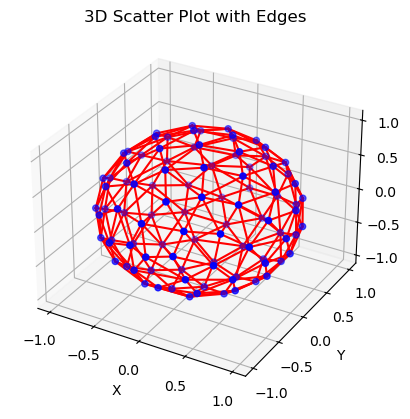

In [19]:
# Visualize vertices and edges in triangulation
plot_3d_scatter_with_edges(vertices_cartesian, edges_cartesian)

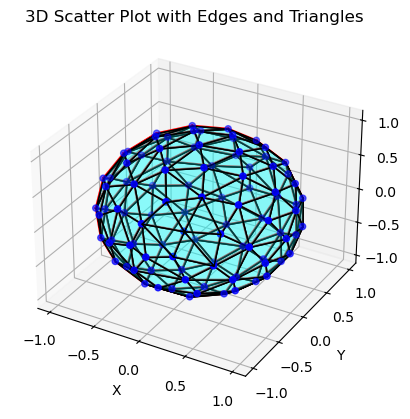

In [20]:
# Visualize vertices, edges, and triangles in triangulation
plot_3d_scatter_with_edges_and_triangles(vertices_cartesian, edges_cartesian, triangles_cartesian)

In [21]:
# Construct mu's, from which the partition of unity {phi_j} will be constructed.
list_of_mus = []
for index in range(num_vertices_in_delaunay_triangulation):
    mu_function = generic_mu(index, vertices_cartesian, triangles_cartesian, triangles_as_indices)
    list_of_mus.append(mu_function)

/var/folders/yg/23gp3k513f198d0sqw9ysb100000gq/T/ipykernel_51100/1379877175.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


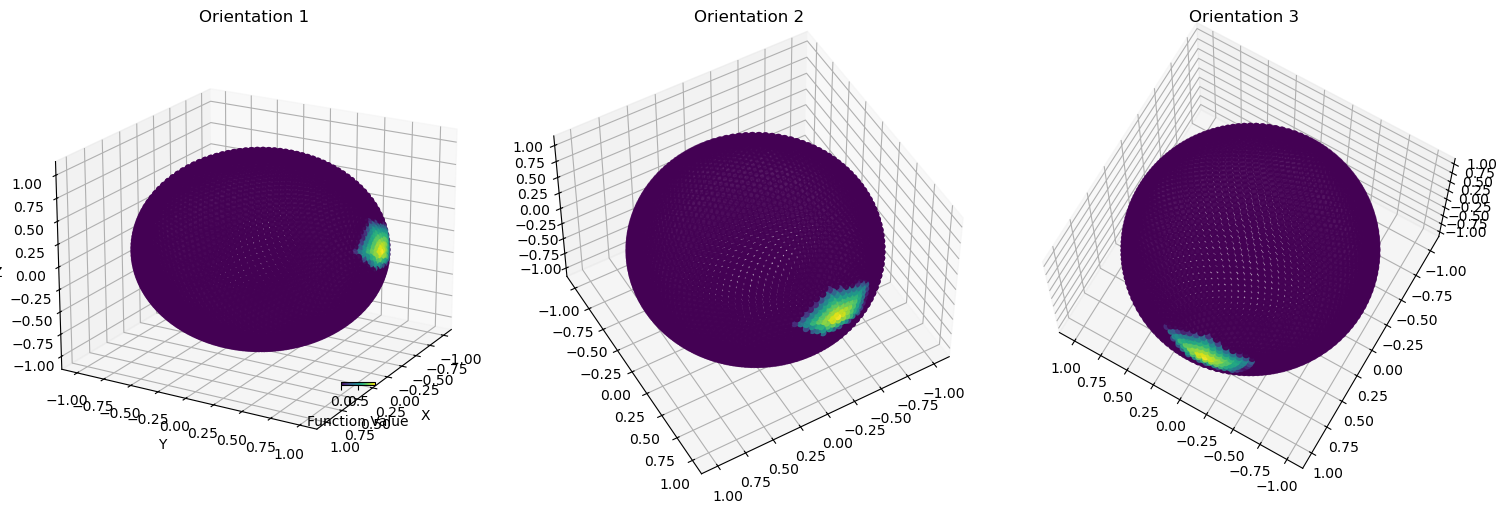

In [22]:
# Visualise mu's, if desired.
# Visualize the functions
num_points_to_visualize_mus = 5000

func = list_of_mus[1]

# Generate points on the unit sphere
points_to_visualize = fibonacci_sphere(num_points_to_visualize_mus)

# Evaluate the function at each point
values = np.array([func(point) for point in points_to_visualize])


# Create subplots with different orientations
fig = plt.figure(figsize=(15, 5))

# First plot
ax1 = fig.add_subplot(131, projection='3d')
scatter1 = ax1.scatter(points_to_visualize[:, 0], points_to_visualize[:, 1], points_to_visualize[:, 2], c=values, cmap='viridis')
ax1.view_init(elev=20, azim=30)  # Adjust the view angle
ax1.set_title('Orientation 1')

# Second plot
ax2 = fig.add_subplot(132, projection='3d')
scatter2 = ax2.scatter(points_to_visualize[:, 0], points_to_visualize[:, 1], points_to_visualize[:, 2], c=values, cmap='viridis')
ax2.view_init(elev=50, azim=60)  # Adjust the view angle
ax2.set_title('Orientation 2')

# Third plot
ax3 = fig.add_subplot(133, projection='3d')
scatter3 = ax3.scatter(points_to_visualize[:, 0], points_to_visualize[:, 1], points_to_visualize[:, 2], c=values, cmap='viridis')
ax3.view_init(elev=70, azim=120)  # Adjust the view angle
ax3.set_title('Orientation 3')

# Add color bar
cbar = fig.colorbar(scatter1, ax=[ax1], shrink=0.1, aspect=10, location='bottom')
# cbar.ax.set_position([0.15, -.2, 0.7, 0.03]) 
cbar.set_label('Function Value')

# Set labels
for ax in [ax1]:
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

# Show plot
plt.tight_layout()
plt.show()

In [23]:
# Create the partition of unity {phi_j}
list_of_phis = []
for index in range(num_vertices_in_delaunay_triangulation):
    phi_function = generic_phi(index, vertices_cartesian, triangles_cartesian, triangles_as_indices)
    list_of_phis.append(phi_function)

In [24]:
# # Visualise mu's, if desired.
# num_points_to_visualize_phis = 1000

# func = list_of_phis[1]

# # Generate points on the unit sphere
# points_to_visualize = fibonacci_sphere(num_points_to_visualize_phis)

# # Evaluate the function at each point
# values = np.array([func(point) for point in points_to_visualize])


# # Create subplots with different orientations
# fig = plt.figure(figsize=(15, 5))

# # First plot
# ax1 = fig.add_subplot(131, projection='3d')
# scatter1 = ax1.scatter(points_to_visualize[:, 0], points_to_visualize[:, 1], points_to_visualize[:, 2], c=values, cmap='viridis')
# ax1.view_init(elev=20, azim=30)  # Adjust the view angle
# ax1.set_title('Orientation 1')

# # Second plot
# ax2 = fig.add_subplot(132, projection='3d')
# scatter2 = ax2.scatter(points_to_visualize[:, 0], points_to_visualize[:, 1], points_to_visualize[:, 2], c=values, cmap='viridis')
# ax2.view_init(elev=50, azim=60)  # Adjust the view angle
# ax2.set_title('Orientation 2')

# # Third plot
# ax3 = fig.add_subplot(133, projection='3d')
# scatter3 = ax3.scatter(points_to_visualize[:, 0], points_to_visualize[:, 1], points_to_visualize[:, 2], c=values, cmap='viridis')
# ax3.view_init(elev=70, azim=120)  # Adjust the view angle
# ax3.set_title('Orientation 3')

# # Add color bar
# cbar = fig.colorbar(scatter1, ax=[ax1], shrink=0.1, aspect=10, location='bottom')
# # cbar.ax.set_position([0.15, -.2, 0.7, 0.03]) 
# cbar.set_label('Function Value')

# # Set labels
# for ax in [ax1]:
#     ax.set_xlabel('X')
#     ax.set_ylabel('Y')
#     ax.set_zlabel('Z')

# # Show plot
# plt.tight_layout()
# plt.show()

# Do cohomology calculation to find harmonic representative of relevant Euler class

In [25]:
# Construct eta, a NON-harmonic representative of [2] \in H^2(S^2, Z)

num_triangles = triangles_as_indices.shape[0]
eta_as_vector = np.zeros((num_triangles, 1))
eta_as_vector[0] = 2.0

In [26]:
# Construct delta_1: C^1(N(U); R) -> Z^2(N(U); R)

num_edges_in_nerve = len(edges_as_indices)

num_triangles_in_nerve = len(triangles_as_indices)

delta_1 = np.zeros((num_triangles_in_nerve, num_edges_in_nerve))


for row_index in range(num_triangles_in_nerve):
    triangle_indices = triangles_as_indices[row_index]
    for col_index in range(num_edges_in_nerve):
        edge_indices = edges_as_indices[col_index]

        triangle_v1 = triangle_indices[0]
        triangle_v2 = triangle_indices[1]
        triangle_v3 = triangle_indices[2]

        if np.array_equal(edge_indices, np.array([triangle_v2, triangle_v3])):
            delta_1[row_index, col_index] = 1.0
        elif np.array_equal(edge_indices, np.array([triangle_v1, triangle_v3])):
            delta_1[row_index, col_index] = -1.0
        elif np.array_equal(edge_indices, np.array([triangle_v1, triangle_v2])):
            delta_1[row_index, col_index] = 1.0


In [27]:
# Construct Moore-Penrose pseudo-inverse of delta_1
inv_delta_1 = np.linalg.pinv(delta_1)

In [28]:
# Construct image of eta under induced map Z^2(N(U), Z) -> Z^2(N(U); R)
i_sharp_eta = np.zeros((num_triangles_in_nerve))
for index in range(num_triangles_in_nerve):
    i_sharp_eta[index] = 1*eta_as_vector[index]

/var/folders/yg/23gp3k513f198d0sqw9ysb100000gq/T/ipykernel_51100/1610327795.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  i_sharp_eta[index] = 1*eta_as_vector[index]


In [29]:
# Construct harmonic representative theta of eta

nu = inv_delta_1@i_sharp_eta

theta = eta_as_vector - ((delta_1@nu).reshape((num_triangles_in_nerve, 1)))

# Sample points on unit sphere

In [30]:
# Note: for these example distributions, please choose a number that is divisble by both 2 and 3 (i.e., divisible by 6).
num_points_to_sample_on_sphere = 1500

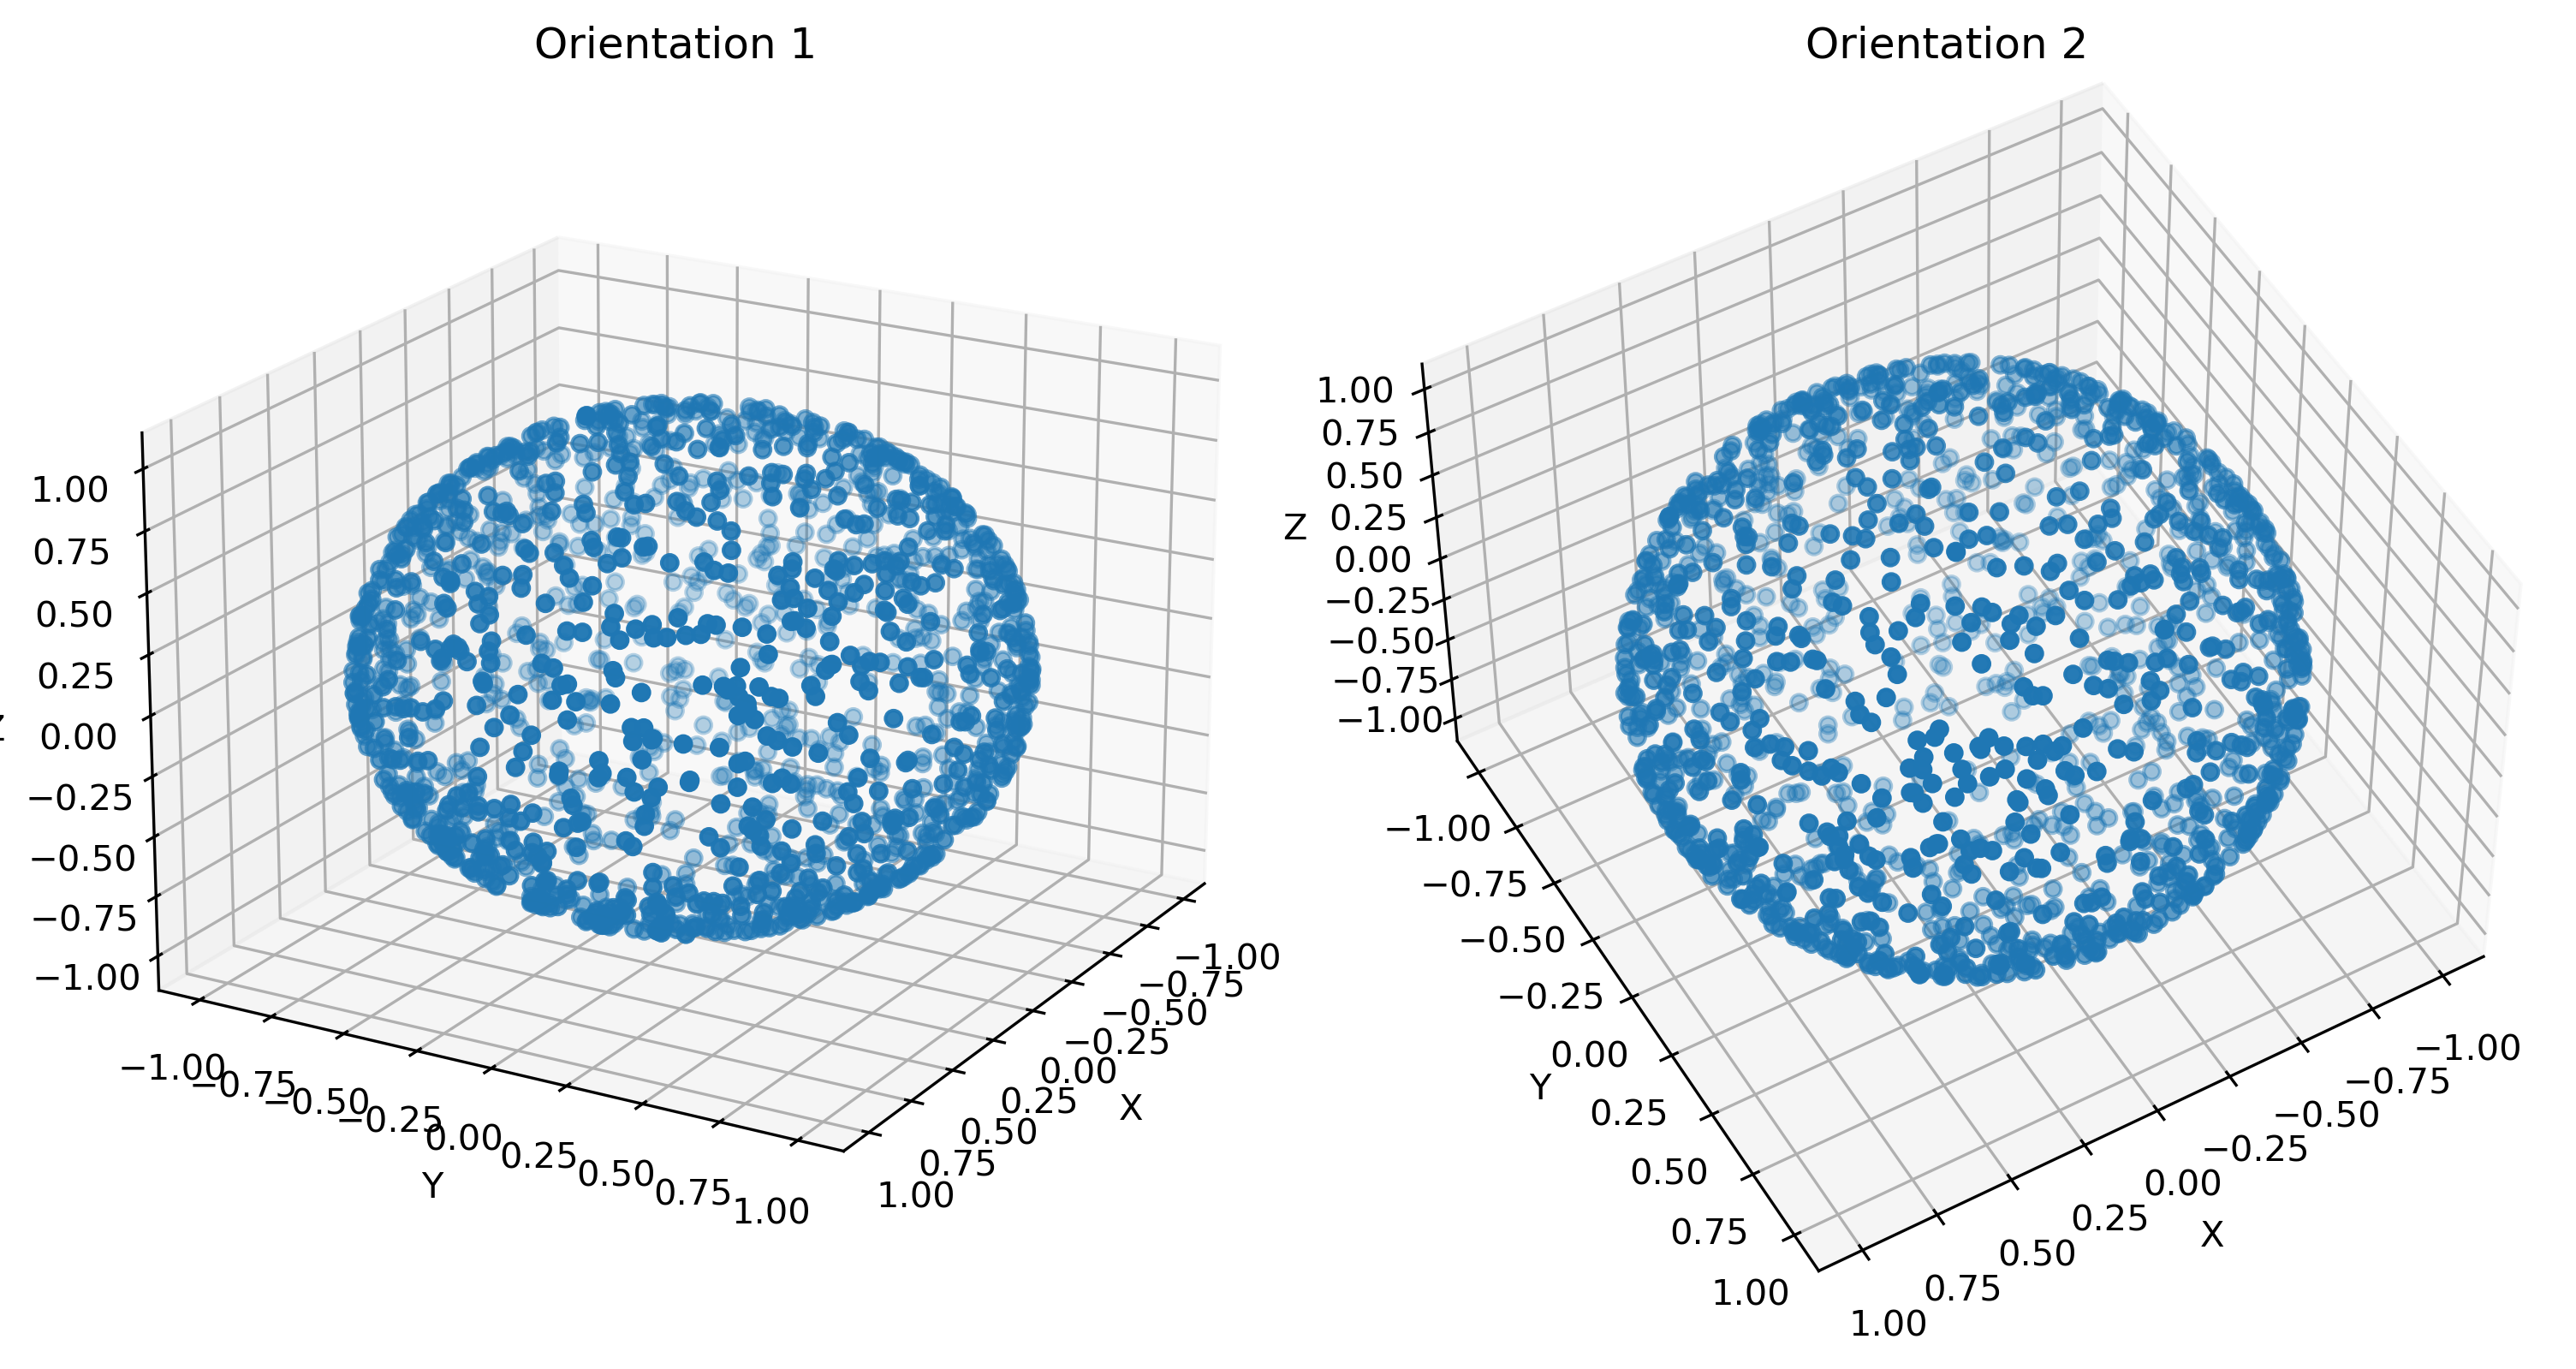

In [31]:
# Uniform distribution
def sample_unit_sphere(num_points):
    phi = np.random.uniform(0, 2 * np.pi, num_points)
    costheta = np.random.uniform(-1, 1, num_points)
    theta = np.arccos(costheta)
    
    x = np.sin(theta) * np.cos(phi)
    y = np.sin(theta) * np.sin(phi)
    z = np.cos(theta)
    
    return np.vstack((x, y, z)).T

example_points = sample_unit_sphere(num_points_to_sample_on_sphere)

# Create subplots with different orientations
fig = plt.figure(figsize=(15, 5), dpi = 300)

# First plot
ax1 = fig.add_subplot(131, projection='3d')
scatter1 = ax1.scatter(example_points[:, 0], example_points[:, 1], example_points[:, 2])
ax1.view_init(elev=20, azim=30)  # Adjust the view angle
ax1.set_title('Orientation 1')

# Second plot
ax2 = fig.add_subplot(132, projection='3d')
scatter2 = ax2.scatter(example_points[:, 0], example_points[:, 1], example_points[:, 2])
ax2.view_init(elev=50, azim=60)  # Adjust the view angle
ax2.set_title('Orientation 2')

# # Third plot
# ax3 = fig.add_subplot(133, projection='3d')
# scatter3 = ax3.scatter(example_points[:, 0], example_points[:, 1], example_points[:, 2])
# ax3.view_init(elev=70, azim=120)  # Adjust the view angle
# ax3.set_title('Orientation 3')

# Set labels
for ax in [ax1, ax2]:
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

# Show plot
plt.tight_layout()
plt.show()

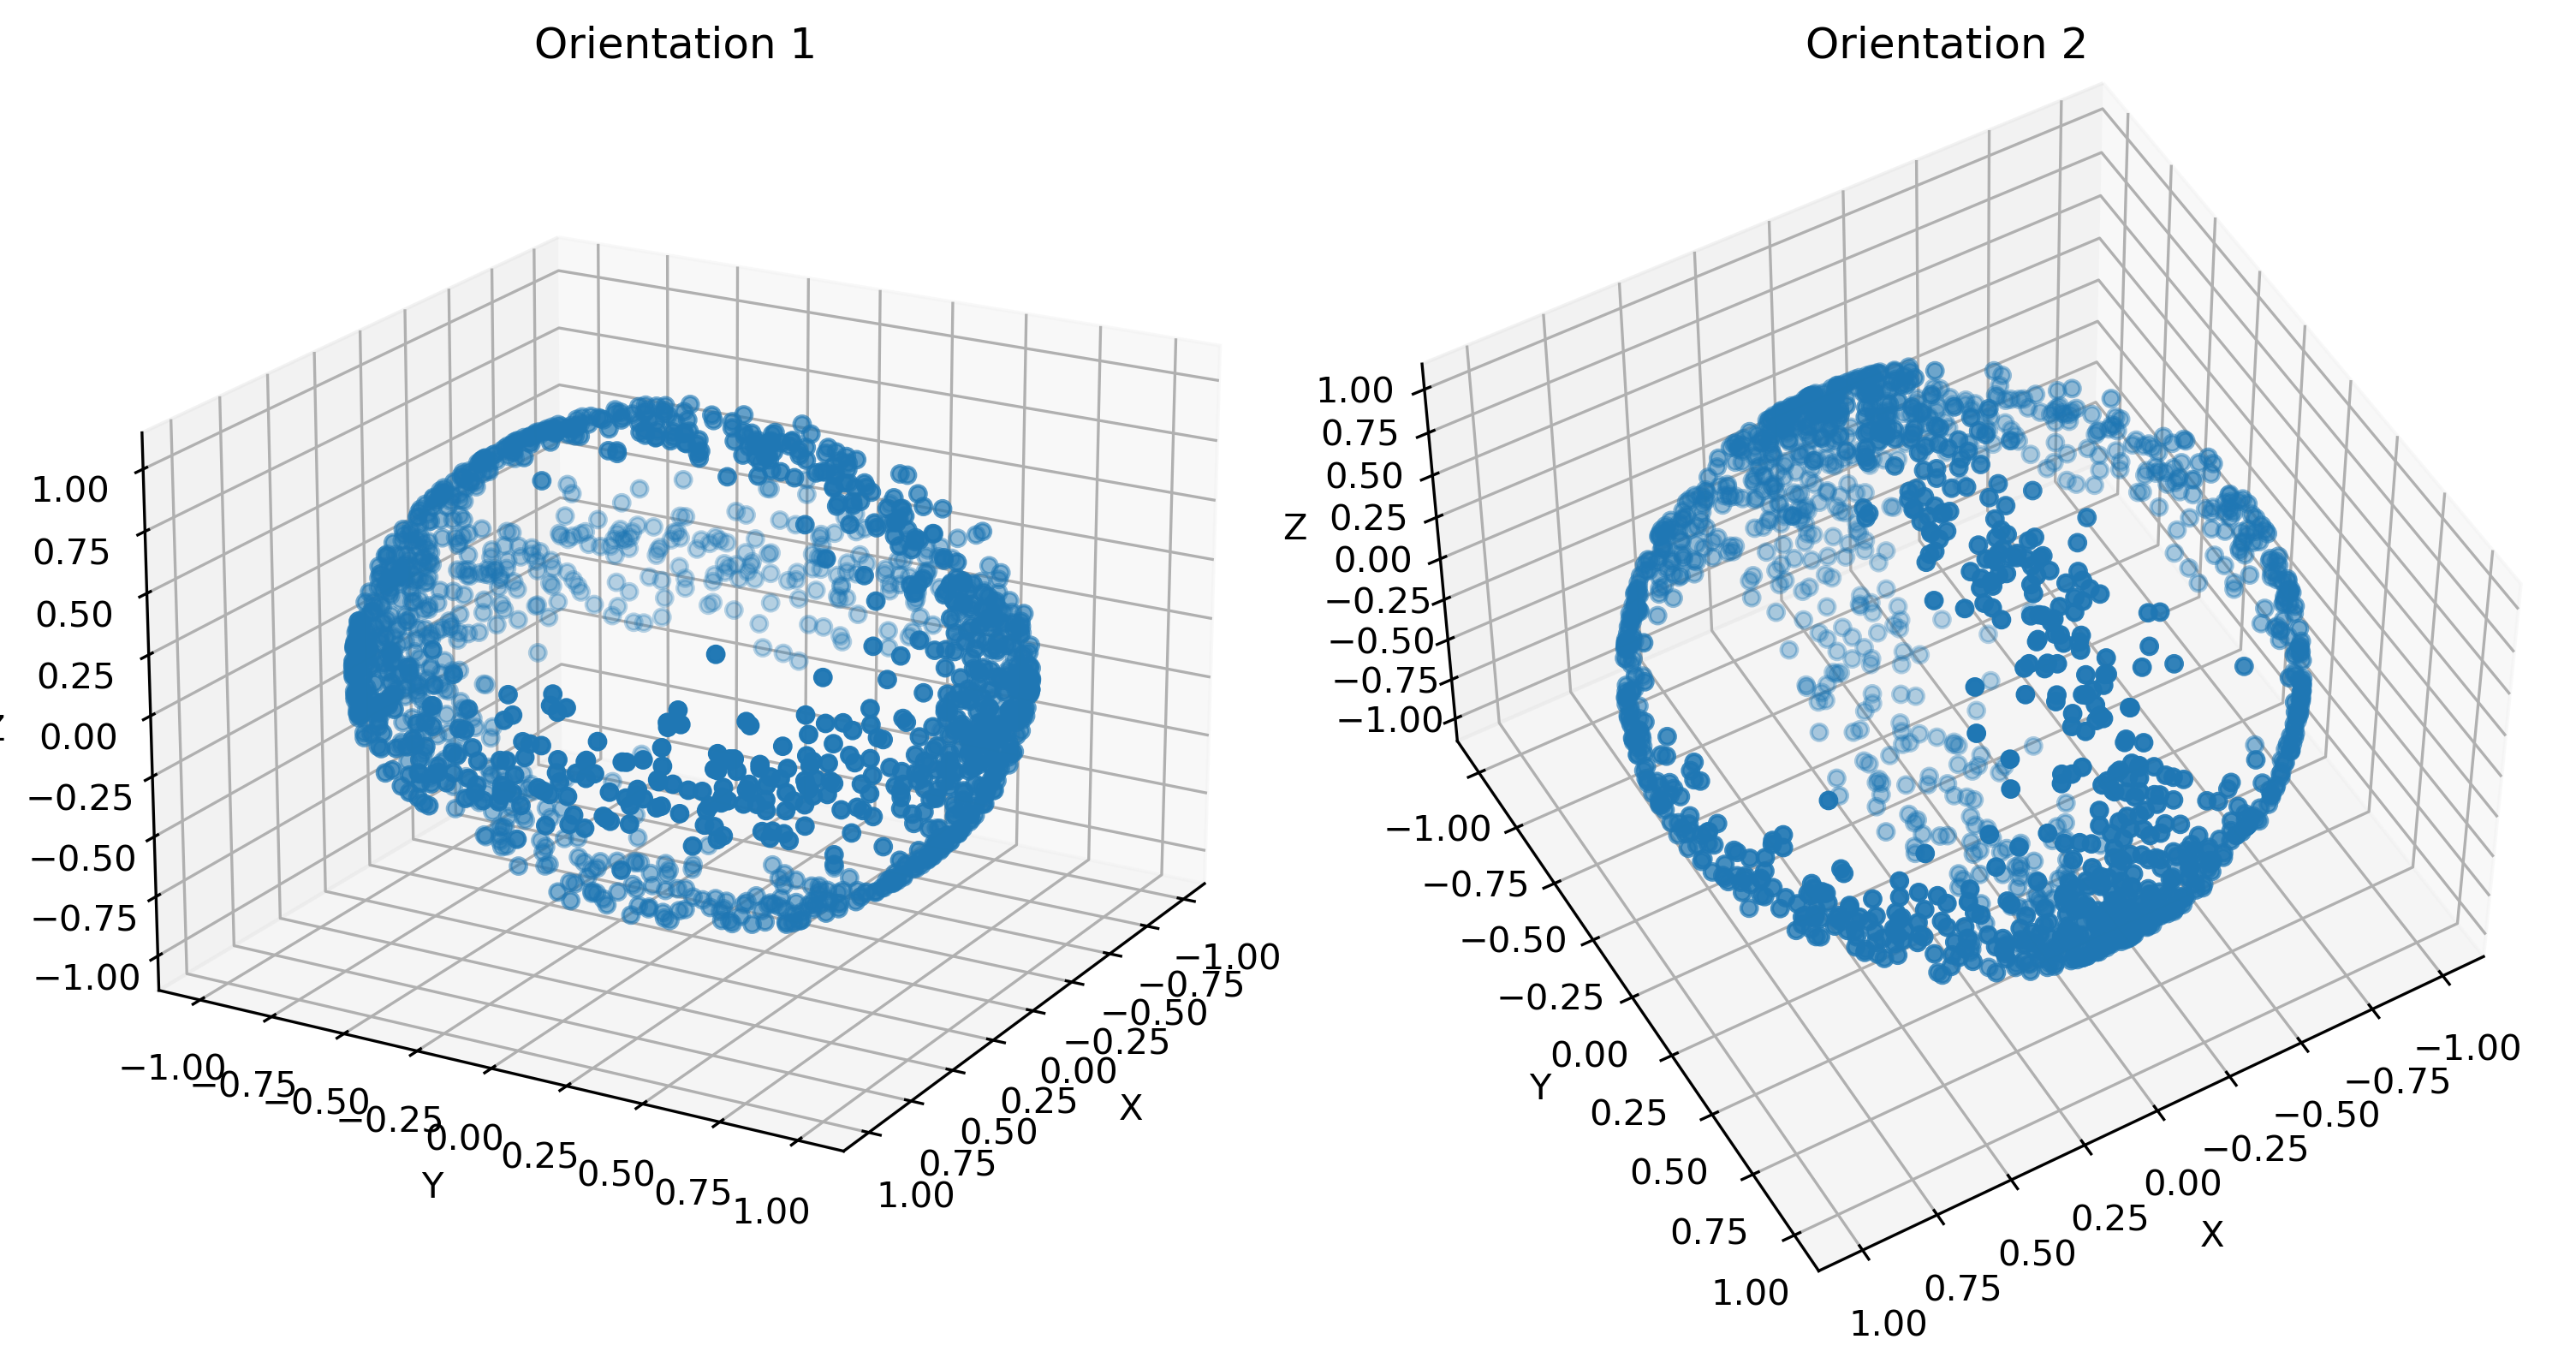

In [32]:
# Orthogonal equators

def sample_dual_equators(num_points, sigma=0.1, weight_ns=0.5):
    """
    Sample points on the unit sphere with concentrations around both the north-south and east-west equators.
    
    Parameters:
    - n_samples: Number of points to sample.
    - sigma: Standard deviation of the Gaussian distribution around the equators.
    - weight_ns: The weight of the samples around the north-south equator (0 to 1).
    
    Returns:
    - points: Array of sampled points on the unit sphere.
    """
    # Allocate samples to north-south and east-west equators
    n_ns = int(num_points * weight_ns)
    n_ew = num_points - n_ns
    
    # North-South equator samples
    phi_ns = np.random.uniform(0, 2 * np.pi, n_ns)
    theta_ns = np.random.normal(np.pi / 2, sigma, n_ns)
    
    # Convert spherical coordinates to Cartesian for North-South equator
    x_ns = np.sin(theta_ns) * np.cos(phi_ns)
    y_ns = np.sin(theta_ns) * np.sin(phi_ns)
    z_ns = np.cos(theta_ns)
    
    # East-West equator samples
    phi_ew = np.random.uniform(0, 2 * np.pi, n_ew)
    theta_ew = np.random.normal(np.pi / 2, sigma, n_ew)
    
    # Convert spherical coordinates to Cartesian for East-West equator
    # Here we effectively rotate the points by 90 degrees around the y-axis
    x_ew = np.cos(theta_ew)
    y_ew = np.sin(theta_ew) * np.sin(phi_ew)
    z_ew = np.sin(theta_ew) * np.cos(phi_ew)
    
    # Combine both sets of points
    x = np.concatenate((x_ns, x_ew))
    y = np.concatenate((y_ns, y_ew))
    z = np.concatenate((z_ns, z_ew))
    
    return np.vstack([x, y, z]).T

# Standard deviation of the Gaussian distribution around the equators
sigma = 0.15

# Weight for the north-south equator (0.5 means equal weight to both equators)
weight_ns = 0.5

# Generate points on the unit sphere with concentration around both equators
example_points = sample_dual_equators(num_points_to_sample_on_sphere, sigma, weight_ns)


# Create subplots with different orientations
fig = plt.figure(figsize=(15, 5), dpi = 300)

# First plot
ax1 = fig.add_subplot(131, projection='3d')
scatter1 = ax1.scatter(example_points[:, 0], example_points[:, 1], example_points[:, 2])
ax1.view_init(elev=20, azim=30)  # Adjust the view angle
ax1.set_title('Orientation 1')

# Second plot
ax2 = fig.add_subplot(132, projection='3d')
scatter2 = ax2.scatter(example_points[:, 0], example_points[:, 1], example_points[:, 2])
ax2.view_init(elev=50, azim=60)  # Adjust the view angle
ax2.set_title('Orientation 2')

# # Third plot
# ax3 = fig.add_subplot(133, projection='3d')
# scatter3 = ax3.scatter(example_points[:, 0], example_points[:, 1], example_points[:, 2])
# ax3.view_init(elev=70, azim=120)  # Adjust the view angle
# ax3.set_title('Orientation 3')

# Set labels
for ax in [ax1, ax2]:
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

# Show plot
plt.tight_layout()
plt.show()

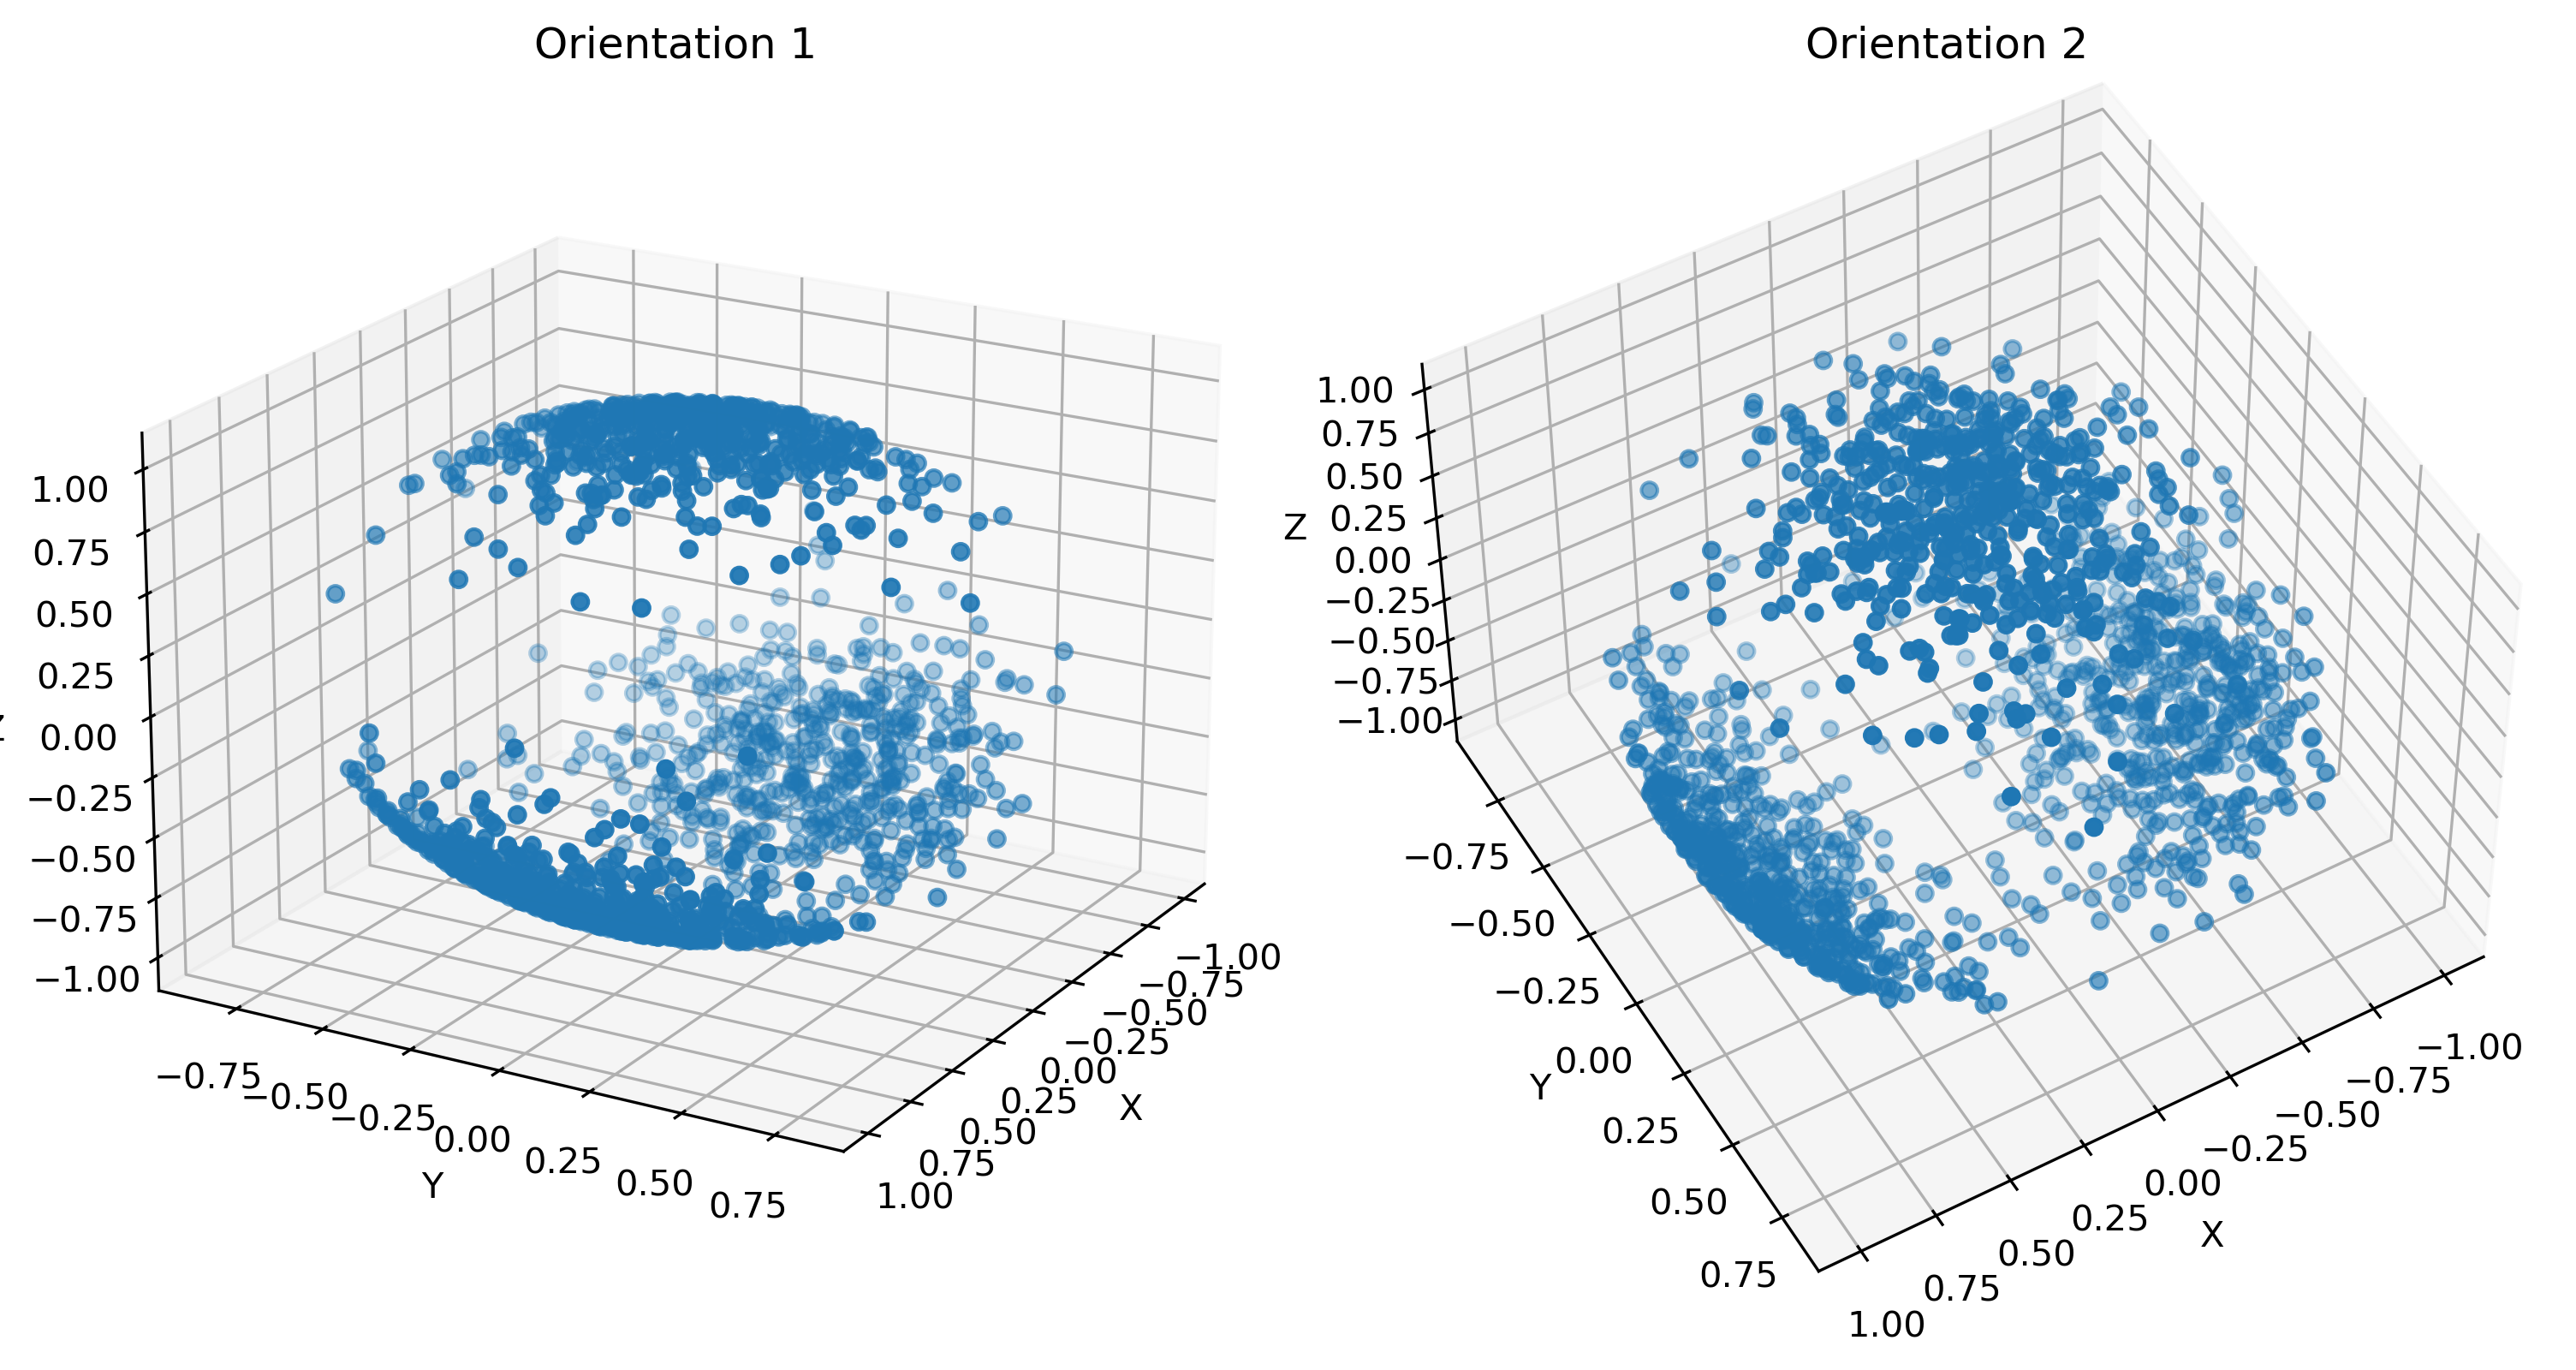

In [33]:
# Gaussian distributions around three different points

def sample_around_point_on_sphere(center_point, num_points, standard_deviation):
    """
    Generate samples on the unit sphere with a normal distribution centered around a given point.
    
    Parameters:
    - center_point: A 3D numpy array representing the point on the unit sphere.
    - num_points: Number of points to sample.
    - standard_deviation: Standard deviation of the Gaussian distribution.
    
    Returns:
    - samples: A numpy array of shape (num_points, 3) with the sampled points on the sphere.
    """
    # Normalize the center point to ensure it lies on the unit sphere
    center_point = center_point / np.linalg.norm(center_point)
    
    # Generate random samples in 3D space centered around the origin with normal distribution
    random_samples = np.random.normal(loc=0, scale=standard_deviation, size=(num_points, 3))
    
    # Translate the samples to be centered around the given point on the sphere
    random_samples += center_point
    
    # Normalize each sample to project it onto the unit sphere
    samples = random_samples / np.linalg.norm(random_samples, axis=1, keepdims=True)
    
    return samples


def sample_around_multiple_points_on_sphere(center_point_1, center_point_2, center_point_3, num_points_in_each_sample, standard_deviation):

    center_point_1 = np.array([0,0,1])
    center_point_2 = np.array([1/np.sqrt(2), 0, -1/np.sqrt(2)])
    center_point_3 = np.array([-1/np.sqrt(2), 0, -1/np.sqrt(2)])

    sample_1 = sample_around_point_on_sphere(center_point_1, num_points_in_each_sample, standard_deviation)
    sample_2 = sample_around_point_on_sphere(center_point_2, num_points_in_each_sample, standard_deviation)
    sample_3 = sample_around_point_on_sphere(center_point_3, num_points_in_each_sample, standard_deviation)

    aux = np.vstack((sample_1, sample_2))
    
    return np.vstack((aux, sample_3))


example_points = sample_around_multiple_points_on_sphere(np.array([0,0,1]), np.array([1/np.sqrt(2), 0, -1/np.sqrt(2)]), np.array([-1/np.sqrt(2), 0, -1/np.sqrt(2)]), 500, 0.3)


# Create subplots with different orientations
fig = plt.figure(figsize=(15, 5), dpi = 300)

# First plot
ax1 = fig.add_subplot(131, projection='3d')
scatter1 = ax1.scatter(example_points[:, 0], example_points[:, 1], example_points[:, 2])
ax1.view_init(elev=20, azim=30)  # Adjust the view angle
ax1.set_title('Orientation 1')

# Second plot
ax2 = fig.add_subplot(132, projection='3d')
scatter2 = ax2.scatter(example_points[:, 0], example_points[:, 1], example_points[:, 2])
ax2.view_init(elev=50, azim=60)  # Adjust the view angle
ax2.set_title('Orientation 2')

# # Third plot
# ax3 = fig.add_subplot(133, projection='3d')
# scatter3 = ax3.scatter(example_points[:, 0], example_points[:, 1], example_points[:, 2])
# ax3.view_init(elev=70, azim=120)  # Adjust the view angle
# ax3.set_title('Orientation 3')

# Set labels
for ax in [ax1, ax2]:
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

# Show plot
plt.tight_layout()
plt.show()

In [34]:
# Select sample points for analysis
sampled_points_on_sphere = sample_around_multiple_points_on_sphere(np.array([0,0,1]), np.array([1/np.sqrt(2), 0, -1/np.sqrt(2)]), np.array([-1/np.sqrt(2), 0, -1/np.sqrt(2)]), 500, 0.3)

# Precompute mu's, phi's, and construct transition functions for tangent bundle

In [35]:
precomputed_mus = np.zeros((num_vertices_in_delaunay_triangulation, num_points_to_sample_on_sphere))

for vertex_index in range(num_vertices_in_delaunay_triangulation):
    print(f'Working on mu {vertex_index}')
    for point_index in range(num_points_to_sample_on_sphere):
        mu_function = list_of_mus[vertex_index]
        point = sampled_points_on_sphere[point_index]
        value = mu_function(point)
        precomputed_mus[vertex_index, point_index] = value

Working on mu 0
Working on mu 1
Working on mu 2
Working on mu 3
Working on mu 4
Working on mu 5
Working on mu 6
Working on mu 7
Working on mu 8
Working on mu 9
Working on mu 10
Working on mu 11
Working on mu 12
Working on mu 13
Working on mu 14
Working on mu 15
Working on mu 16
Working on mu 17
Working on mu 18
Working on mu 19
Working on mu 20
Working on mu 21
Working on mu 22
Working on mu 23
Working on mu 24
Working on mu 25
Working on mu 26
Working on mu 27
Working on mu 28
Working on mu 29
Working on mu 30
Working on mu 31
Working on mu 32
Working on mu 33
Working on mu 34
Working on mu 35
Working on mu 36
Working on mu 37
Working on mu 38
Working on mu 39
Working on mu 40
Working on mu 41
Working on mu 42
Working on mu 43
Working on mu 44
Working on mu 45
Working on mu 46
Working on mu 47
Working on mu 48
Working on mu 49
Working on mu 50
Working on mu 51
Working on mu 52
Working on mu 53
Working on mu 54
Working on mu 55
Working on mu 56
Working on mu 57
Working on mu 58
Working

In [36]:
precomputed_phis = np.zeros((num_vertices_in_delaunay_triangulation, num_points_to_sample_on_sphere))

for vertex_index in range(num_vertices_in_delaunay_triangulation):
    for point_index in range(num_points_to_sample_on_sphere):
        mu_value = precomputed_mus[vertex_index, point_index]
        denominator = np.sum(precomputed_mus, axis = 0)[point_index]
        precomputed_phis[vertex_index, point_index] = mu_value/denominator

In [37]:
def precomputed_alpha(j,l,index_of_point_in_list_of_points):
    if j == l: 
        return np.array([0.0])
    elif j < l:
        sign_coefficient = 1
        (edge_boolean, edge_index) = find_index(np.array([j,l]), edges_as_indices)
        if edge_boolean == True:
            nu_value = nu[edge_index]
            sum = 0.0
            for m_index in range(num_vertices_in_delaunay_triangulation):
                tup = (j,l,m_index)
                sign = permutation_sign(tup)
                sorted_tuple = tuple(sorted(tup))
                if sorted_tuple in triangle_indices_dict:
                    triangle_index = triangle_indices_dict[sorted_tuple]
                    value = precomputed_phis[m_index, index_of_point_in_list_of_points]*theta[triangle_index]
                    sum = sum + (sign*value)
            return sign_coefficient*(nu_value + sum)
        else:
            return np.array([0.0])
    else:
        sign_coefficient = -1
        (edge_boolean, edge_index) = find_index(np.array([l,j]), edges_as_indices)
        if edge_boolean == True:
            nu_value = nu[edge_index]
            sum = 0.0
            for m_index in range(num_vertices_in_delaunay_triangulation):
                tup = (j,l,m_index)
                sign = permutation_sign(tup)
                sorted_tuple = tuple(sorted(tup))
                if sorted_tuple in triangle_indices_dict:
                    triangle_index = triangle_indices_dict[sorted_tuple]
                    value = precomputed_phis[m_index, index_of_point_in_list_of_points]*theta[triangle_index]
                    sum = sum + (sign*value)
            return sign_coefficient*(nu_value + sum)
        else:
            return np.array([0.0])

In [38]:
def precomputed_harmonic_OMEGA(j,l,index_of_point_in_list_of_points):
    matrix = np.zeros((2,2))
    matrix[0,0] = np.cos(2*np.pi*precomputed_alpha(j,l,index_of_point_in_list_of_points)[0])
    matrix[0,1] = -1*np.sin(2*np.pi*precomputed_alpha(j,l,index_of_point_in_list_of_points)[0])
    matrix[1,0] = np.sin(2*np.pi*precomputed_alpha(j,l,index_of_point_in_list_of_points)[0])
    matrix[1,1] = np.cos(2*np.pi*precomputed_alpha(j,l,index_of_point_in_list_of_points)[0])
    return matrix

# Embed points in high-dimensional Stiefel manifold

In [39]:
# For the tangent bundle, k = 2 and N = J*2, where J is equal to the number of vertices in the triangulation, which is also the number of open sets in the trivializing open cover
k = 2
N = 2*num_vertices_in_delaunay_triangulation

num_open_sets = num_vertices_in_delaunay_triangulation

points_in_stiefel = np.zeros((num_points_to_sample_on_sphere,N, k))


In [40]:
# One more precomputation step for efficiency

barycenters_of_triangles = find_barycenters_of_triangles(triangles_cartesian)

triangle_indices_dict = {}
for (index, triangle_indices) in enumerate(triangles_as_indices):
    triangle_indices_dict[tuple(triangle_indices)] = index

In [41]:
# Embedd points in V_k(R^N)

for point_index in range(num_points_to_sample_on_sphere):
    print(f'Working on index {point_index} out of {num_points_to_sample_on_sphere}.')
    point = sampled_points_on_sphere[point_index]
    start_time = time.time()
    vertex_indices_whose_stars_contain_point = find_stars_that_contain_point(np.array(point), triangles_as_indices, triangles_cartesian, barycenters_of_triangles)
    
    # Take the first one 
    index_of_containing_u = vertex_indices_whose_stars_contain_point[0]
    end_time = time.time()
    print(f"Execution time to find containing open set: {end_time - start_time} seconds")
    if index_of_containing_u > num_open_sets - 1:
        raise Exception(f'Containing open set not found for {point}')
    for j in range(num_open_sets):
        # print(f'Working on sub-problem {j} out of {num_open_sets}')
        phi_function = list_of_phis[j]
        start_time = time.time()
        # coefficient = np.sqrt(phi_function(point))
        phi_value = precomputed_phis[j, point_index]
        coefficient = np.sqrt(phi_value)
        end_time = time.time()
        # print(f"Execution time to find coefficient: {end_time - start_time} seconds")

        start_time = time.time()
        omega_matrix = precomputed_harmonic_OMEGA(j, index_of_containing_u, point_index)
        end_time = time.time()
        # print(f"Execution time to find omega_matrix: {end_time - start_time} seconds")

        matrix = coefficient*omega_matrix
        points_in_stiefel[point_index, range(2*j, 2*j+2), :] = matrix

Working on index 0 out of 1500.
Found containing triangle on list index 2
Execution time to find containing open set: 0.0010862350463867188 seconds
Working on index 1 out of 1500.
Found containing triangle on list index 1
Execution time to find containing open set: 0.0006761550903320312 seconds
Working on index 2 out of 1500.
Found containing triangle on list index 1
Execution time to find containing open set: 0.0006260871887207031 seconds
Working on index 3 out of 1500.
Found containing triangle on list index 1
Execution time to find containing open set: 0.0006880760192871094 seconds
Working on index 4 out of 1500.
Found containing triangle on list index 1
Execution time to find containing open set: 0.0008840560913085938 seconds
Working on index 5 out of 1500.
Found containing triangle on list index 1
Execution time to find containing open set: 0.0008640289306640625 seconds
Working on index 6 out of 1500.
Found containing triangle on list index 1
Execution time to find containing open

# Perform PSC

### Note: for completeness, we compute alpha_GD initialized from both alpha_PCA and a randomly selected alpha

In [42]:
# Choose target n dimension
n = 3

In [43]:
list_projection_costs_for_alpha_random = np.array([])
list_projection_costs_for_alpha_pca = np.array([])
list_projection_costs_for_alpha_gd_from_pca = np.array([])
list_projection_costs_for_alpha_gd_from_random = np.array([])

In [44]:
ys = points_in_stiefel


# DO DIMENSIONALITY REUDCTION WITH VARIOUS ALPHA'S
St_Nn = Stiefel(N, n)
alpha_random = St_Nn.random_point() # for comparison
alpha_PCA = PCA(ys, n)
alpha_GD_from_PCA = manopt_alpha(ys, alpha_PCA)
alpha_GD_from_random = manopt_alpha(ys, alpha_random)





# GET L2 PROJECTION COSTS FOR EACH ALPHA
# L2 projection costs for random
random_l2_projection_costs = []

yhats = yhat_alpha_all(alpha_random, ys)

for index in range(yhats.shape[0]):
    yhat = yhats[index, :, :]
    alpha_random_yhat = alpha_random@(yhat)
    y = ys[index, :, :]
    distance = np.linalg.norm(y - alpha_random_yhat)
    random_l2_projection_costs.append(distance)


# L2 projection costs for PCA
pca_l2_projection_costs = []

yhats = yhat_alpha_all(alpha_PCA, ys)

for index in range(yhats.shape[0]):
    yhat = yhats[index, :, :]
    alpha_PCA_yhat = alpha_PCA@(yhat)
    y = ys[index, :, :]
    distance = np.linalg.norm(y - alpha_PCA_yhat)
    pca_l2_projection_costs.append(distance)


# # L2 projection costs for gradient descent from pca
gd_from_pca_l2_projection_costs = []

yhats = yhat_alpha_all(alpha_GD_from_PCA, ys)

for index in range(yhats.shape[0]):
    yhat = yhats[index, :, :]
    alpha_GD_yhat = alpha_GD_from_PCA@(yhat)
    y = ys[index, :, :]
    distance = np.linalg.norm(y - alpha_GD_yhat)
    gd_from_pca_l2_projection_costs.append(distance)


# L2 projection costs for gradient descent from random
gd_from_random_l2_projection_costs = []

yhats = yhat_alpha_all(alpha_GD_from_random, ys)

for index in range(yhats.shape[0]):
    yhat = yhats[index, :, :]
    alpha_GD_yhat = alpha_GD_from_random@(yhat)
    y = ys[index, :, :]
    distance = np.linalg.norm(y - alpha_GD_yhat)
    gd_from_random_l2_projection_costs.append(distance)



# FINAL COST CALCULATIONS
cost_for_random = 0.0
for distance in random_l2_projection_costs:
    cost_for_random = cost_for_random + (distance)**2
cost_for_random = np.sqrt(cost_for_random)

cost_for_pca = 0.0
for distance in pca_l2_projection_costs:
    cost_for_pca = cost_for_pca + (distance)**2
cost_for_pca = np.sqrt(cost_for_pca)

cost_for_gd_from_pca = 0.0
for distance in gd_from_pca_l2_projection_costs:
    cost_for_gd_from_pca = cost_for_gd_from_pca + (distance)**2
cost_for_gd_from_pca = np.sqrt(cost_for_gd_from_pca)

cost_for_gd_from_random = 0.0
for distance in gd_from_random_l2_projection_costs:
    cost_for_gd_from_random = cost_for_gd_from_random + (distance)**2
cost_for_gd_from_random = np.sqrt(cost_for_gd_from_random)


list_projection_costs_for_alpha_random = np.append(list_projection_costs_for_alpha_random, cost_for_random)
list_projection_costs_for_alpha_pca = np.append(list_projection_costs_for_alpha_pca, cost_for_pca)
list_projection_costs_for_alpha_gd_from_pca = np.append(list_projection_costs_for_alpha_gd_from_pca, cost_for_gd_from_pca)
list_projection_costs_for_alpha_gd_from_random = np.append(list_projection_costs_for_alpha_gd_from_random, cost_for_gd_from_random)

Optimizing...
Terminated - max iterations reached after 157.89 seconds.

Optimizing...
Terminated - max iterations reached after 158.79 seconds.



In [45]:
list_projection_costs_for_alpha_random

array([73.07456182])

In [46]:
list_projection_costs_for_alpha_pca

array([67.01118624])

In [47]:
list_projection_costs_for_alpha_gd_from_pca

array([61.84496467])

In [48]:
list_projection_costs_for_alpha_gd_from_random

array([61.84498159])